In [17]:
from neo4j import GraphDatabase
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from getpass import getpass
import networkx as nx

In [4]:
!pip install neo4j pandas plotly

   ---------------------------------------- 0.0/325.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/325.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/325.3 kB ? eta -:--:--
   - -------------------------------------- 10.2/325.3 kB ? eta -:--:--
   - -------------------------------------- 10.2/325.3 kB ? eta -:--:--
   --- ----------------------------------- 30.7/325.3 kB 163.8 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/325.3 kB 163.8 kB/s eta 0:00:02
   ---- ---------------------------------- 41.0/325.3 kB 151.3 kB/s eta 0:00:02
   ---- ---------------------------------- 41.0/325.3 kB 151.3 kB/s eta 0:00:02
   ---- ---------------------------------- 41.0/325.3 kB 151.3 kB/s eta 0:00:02
   ----------- --------------------------- 92.2/325.3 kB 249.8 kB/s eta 0:00:01
   ----------- --------------------------- 92.2/325.3 kB 249.8 kB/s eta 0:00:01
   ----------- -------------------------- 102.4/325.3 kB 210.4 kB/s eta 0:00:02
   

In [19]:
URI = "bolt://localhost:7687"
USER = "neo4j"
PASSWORD = "Kidodo@04"#my password 
DB = "usroadnetwork"

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

In [11]:
# Query Neo4j Metrics Automatically
## Total Intersections
def get_total_intersections(tx):
    result = tx.run("MATCH (i:Intersection) RETURN count(i) AS total")
    return result.single()["total"]

## Total Roads
def get_total_roads(tx):
    result = tx.run("MATCH ()-[r:ROAD]->() RETURN count(r) AS total")
    return result.single()["total"]

## Degree Distribution
def get_degree_distribution(tx):
    query = """
    MATCH (i:Intersection)
    RETURN COUNT { (i)--() } AS degree, count(*) AS frequency
    ORDER BY degree
    """
    return pd.DataFrame(tx.run(query).data())

## Top 10 Most Connected Intersections
def get_top10(tx):
    query = """
    MATCH (i:Intersection)
    RETURN i.id AS intersection, COUNT { (i)--() } AS degree
    ORDER BY degree DESC
    LIMIT 10
    """
    return pd.DataFrame(tx.run(query).data())

## Execute Queries
with driver.session(database=DB) as session:
    total_intersections = session.execute_read(get_total_intersections)
    total_roads = session.execute_read(get_total_roads)
    degree_df = session.execute_read(get_degree_distribution)
    top10_df = session.execute_read(get_top10)


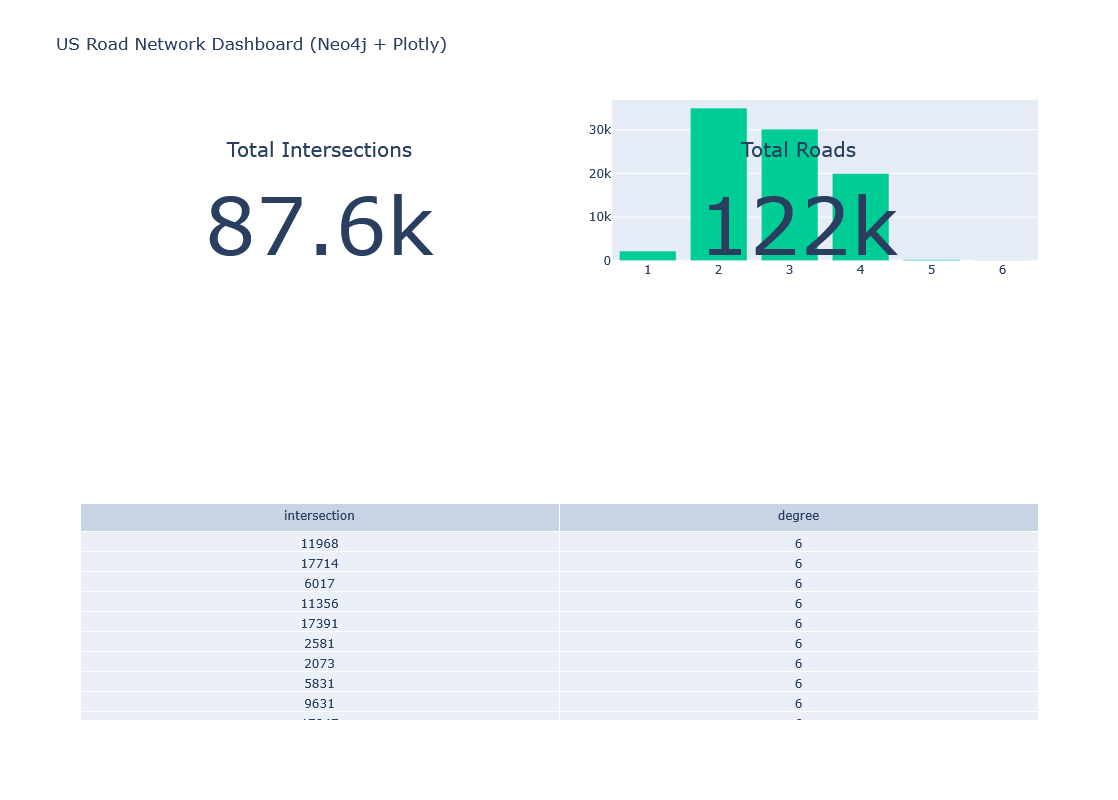

In [21]:
# Build Plotly Dashboard
## KPI Cards
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number",
    value=total_intersections,
    title={"text": "Total Intersections"},
    domain={'x': [0, 0.5], 'y': [0.6, 1]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=total_roads,
    title={"text": "Total Roads"},
    domain={'x': [0.5, 1], 'y': [0.6, 1]}
))

## Degree Distribution Bar Chart
fig.add_trace(go.Bar(
    x=degree_df["degree"],
    y=degree_df["frequency"],
    name="Degree Distribution",
    xaxis="x2",
    yaxis="y2"
))

## Top 10 Intersections Table
fig.add_trace(go.Table(
    header=dict(values=list(top10_df.columns)),
    cells=dict(values=[top10_df[col] for col in top10_df.columns]),
    domain={'x': [0, 1], 'y': [0, 0.35]}
))

## Layout
fig.update_layout(
    title="US Road Network Dashboard (Neo4j + Plotly)",
    grid={'rows': 3, 'columns': 2, 'pattern': "independent"},
    height=800
)

fig.show()


In [9]:
import networkx as nx
import pandas as pd

edges = pd.read_csv(
    r"C:\Users\ntawe\Documents\Data Science\15 Big Data Analytics\Assignment2\edges.csv"
)

G = nx.from_pandas_edgelist(edges, 'source', 'target')

# Approximate using sampling
bc = nx.betweenness_centrality(
    G,
    k=1000,          # number of sampled nodes
    normalized=True,
    seed=42
)

top10 = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10]

for node, score in top10:
    print(node, score)


30524 0.17863774862248055
30645 0.16913217356805177
30625 0.16731069029126813
30643 0.16729514672828044
30621 0.16729131482121
30611 0.1651391576689666
30577 0.16513725076186708
30620 0.1647894595882502
30618 0.16478178823452905
30640 0.16477940426068616


## 9. Degree Distribution Bar Chart (log scale option)

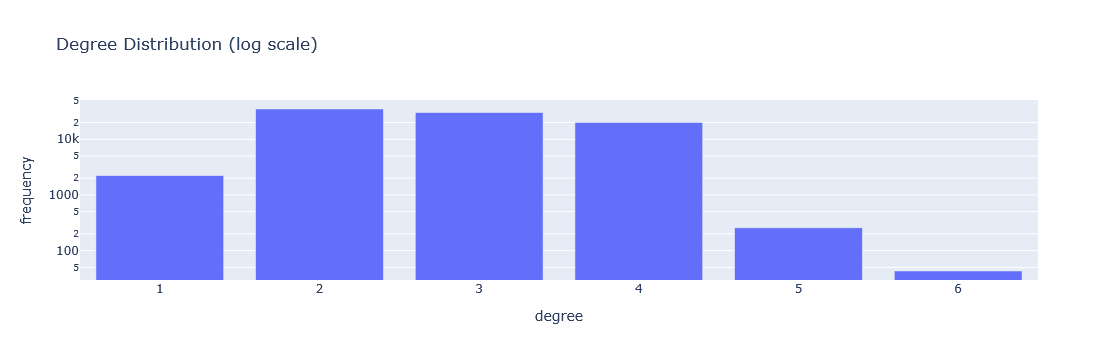

In [23]:
# Degree Distribution Bar Chart (log scale option)

import plotly.express as px

# degree_df = query results from Task 6
fig = px.bar(degree_df, x='degree', y='frequency', title='Degree Distribution (log scale)')
fig.update_yaxes(type='log')
fig.show()